In [1]:
from pretrainedModel import *
from faceRecognition import *

In [2]:
sess, embeddings, images_in, phase_train_in, pnet, rnet, onet = detectionNetwork()

loading the detection/alignment network...
done!
loading the embedding network...
done!


In [3]:
# Path of the references faces that will construct the database of faces
pathsKnown = ["/home/sabrine/Pictures/sabrine.jpg",
              "/home/sabrine/Pictures/cynthia.jpg", 
              "/home/sabrine/Pictures/anthony.jpg",
             "/home/sabrine/Pictures/laurene.jpg",
             "/home/sabrine/Pictures/wissem.jpg"]

# Creation of identities names
names = ['Sabrine', 'Cynthia', 'Anthony', 'Laurene', 'Wissem']

In [4]:
# detection parameters
minsize = 20 
threshold = [ 0.6, 0.7, 0.7 ]
factor = 0.709

detecting faces...


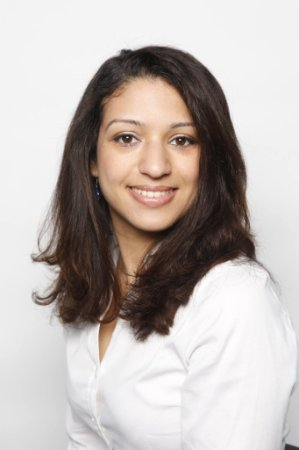

(10, 1)


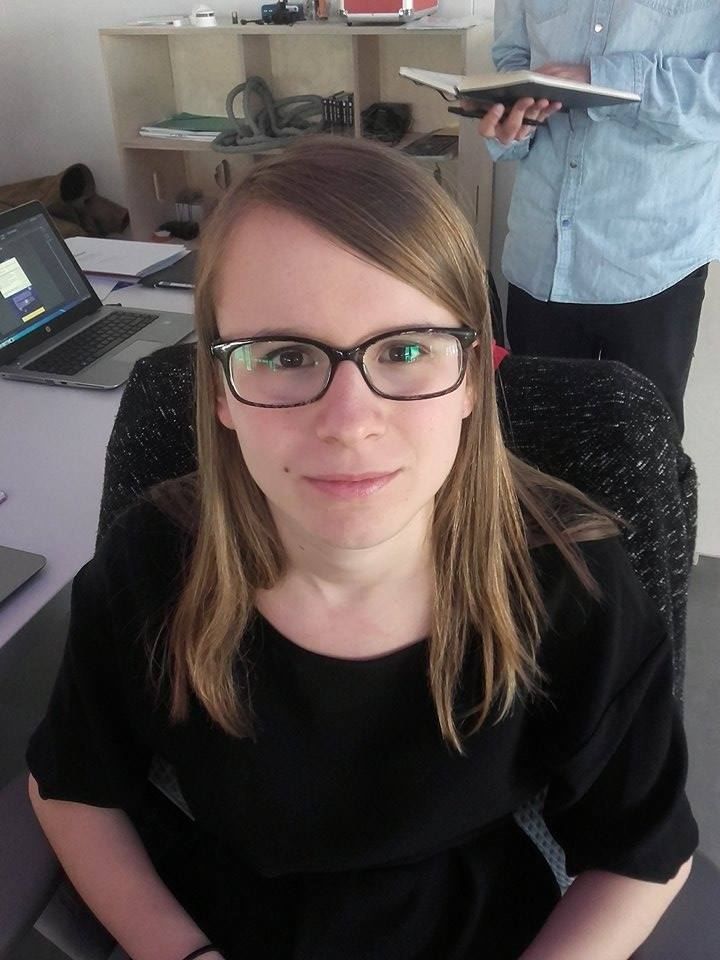

(10, 1)


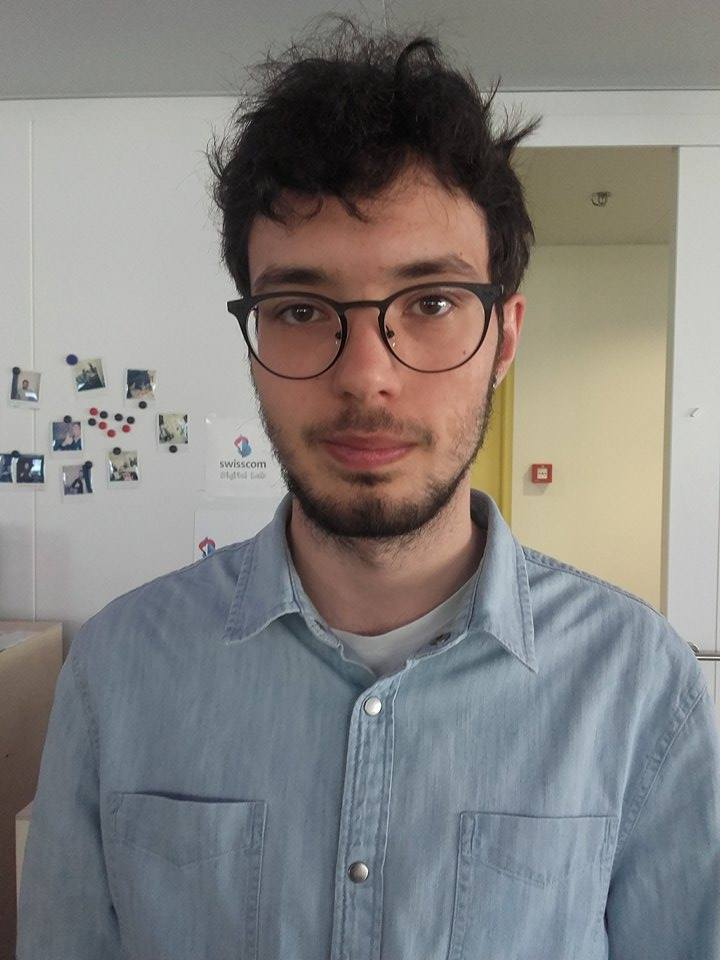

(10, 1)


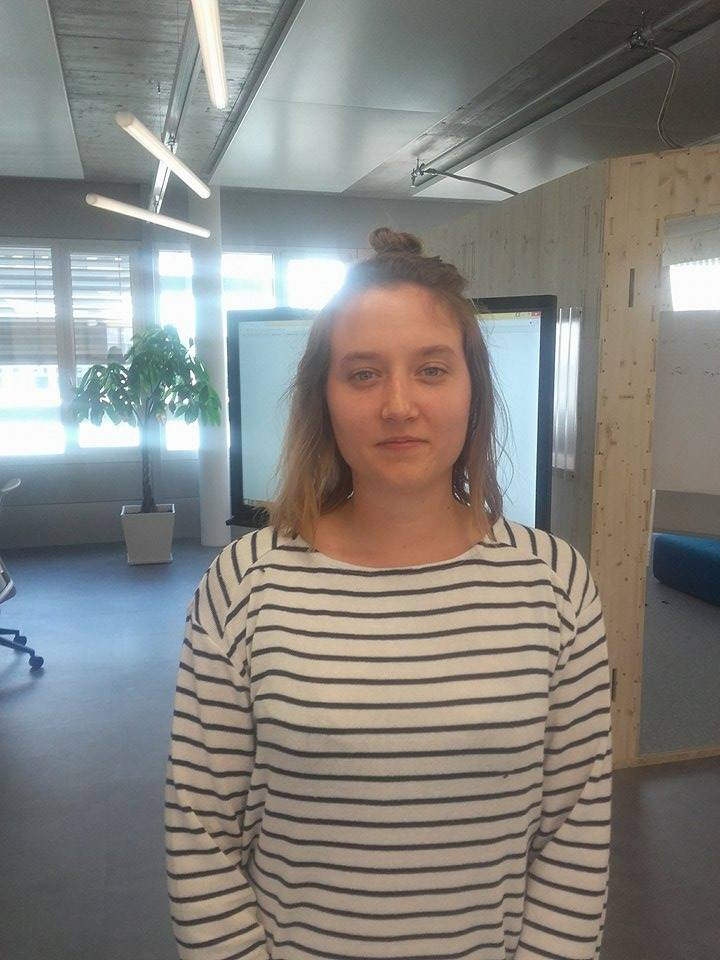

(10, 1)


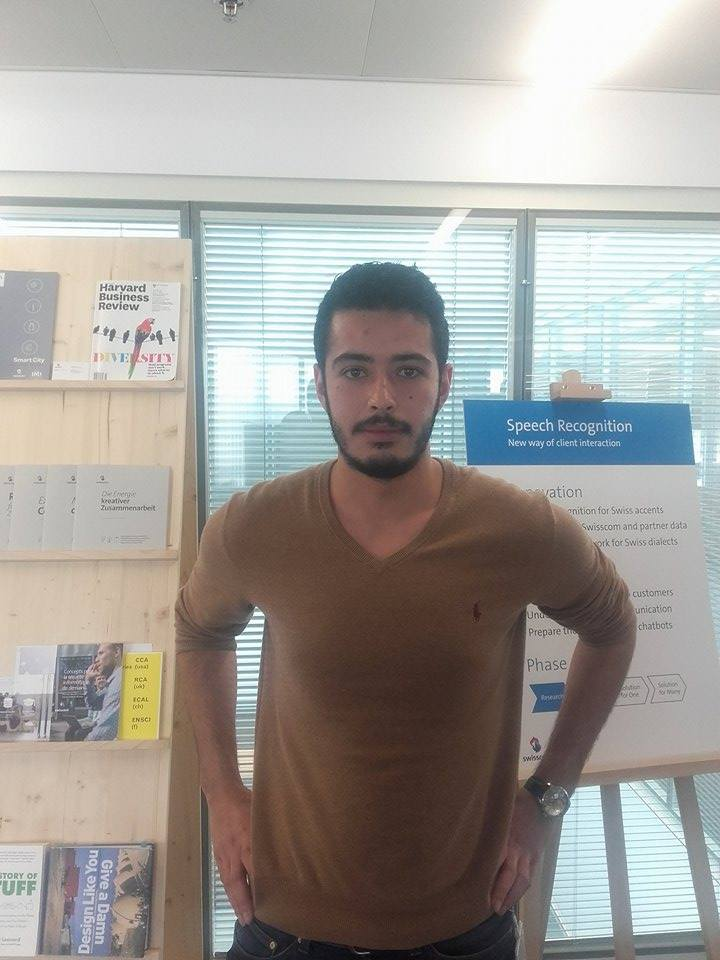

(10, 1)
done!
computing embeddings
done!


In [5]:
df = embeddingKnownFaces(pathsKnown, names, sess, embeddings, images_in,
                   phase_train_in, pnet, rnet, onet,
                   minsize, threshold, factor)

In [6]:
pathUnknown = "/home/sabrine/notebook/framesRGB/1493821815418461311.jpg"

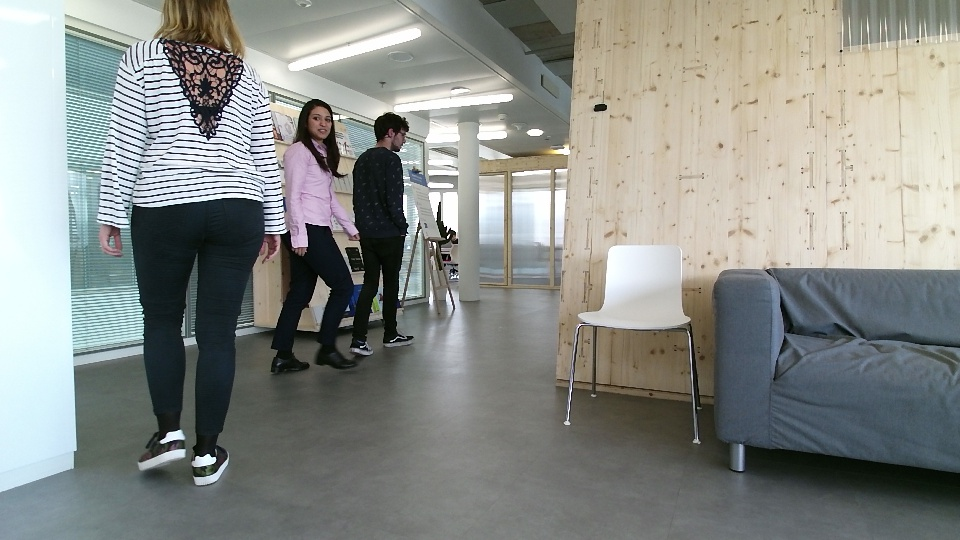

(10, 3)
computing embeddings
done!


In [7]:
unknownFaces_embs, centerCoordinates = embeddingUnknownFaces(pathUnknown,
    sess, embeddings, images_in, phase_train_in, pnet, rnet, onet, 
    minsize, threshold, factor)

In [8]:
import pandas as pd

In [9]:
np.vstack(unknownFaces_embs).shape

(3, 128)

In [10]:
dist = distance.cdist(np.vstack(unknownFaces_embs),
                      pd.DataFrame.as_matrix(df))

In [11]:
pd.DataFrame.as_matrix(df).shape

(5, 128)

In [12]:
len(unknownFaces_embs)

3

In [13]:
dist

array([[ 1.27855141,  1.3248542 ,  1.41977293,  1.26904682,  1.3503532 ],
       [ 1.38927242,  1.25597862,  1.2643608 ,  1.30336172,  1.29887432],
       [ 1.33839605,  1.32294729,  1.35671073,  1.36959835,  1.2947825 ]])

In [14]:
minIndex = np.apply_along_axis(np.argmin, axis=1, arr=dist)

In [15]:
minIndex

array([3, 1, 4])

In [16]:
for index in minIndex:
    print(index)

3
1
4


In [17]:
getNamesAndCoordinates(np.vstack(unknownFaces_embs), pd.DataFrame.as_matrix(df), 
                      centerCoordinates, names)

('centerCoordinate', 3)
3
('name', 'Laurene')
('center', [319, 122])
('distance', 1.2690468181563288)
1
('name', 'Cynthia')
('center', [203, 68])
('distance', 1.2559786206962491)
4
('name', 'Wissem')
('center', [398, 136])
('distance', 1.2947825003854172)


{}